In [2]:
import sys
sys.path.append("../")

In [32]:
import config

import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
import os
import torch


In [10]:
with open(config.COCO14_ANNOT_FILE,'r') as f: data = json.load(f)['data']

In [11]:
data[0].keys()

dict_keys(['parm_pose', 'parm_shape', 'parm_cam', 'bbox_scale', 'bbox_center', 'gt_keypoint_2d', 'joint_validity_openpose18', 'smpltype', 'annotId', 'imageName'])

In [15]:
img = cv2.imread(os.path.join(config.COCO14_IMAGES_FOLDER,data[0]['imageName']))

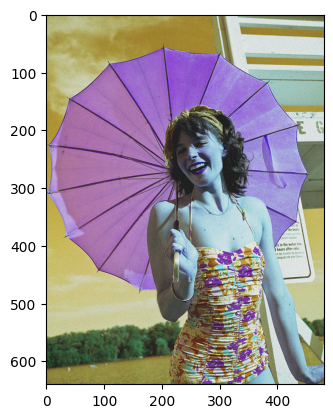

In [18]:
plt.imshow(img)

In [26]:
new_img = img.copy()
visible = []
for j in range(len(data[0]['gt_keypoint_2d'])):
    point = data[0]['gt_keypoint_2d'][j]
    if point[2]>0:
        visible.append(j)
        new_img = cv2.circle(new_img,(int(point[0]),int(point[1])),4,(0,255,0),thickness=-1)

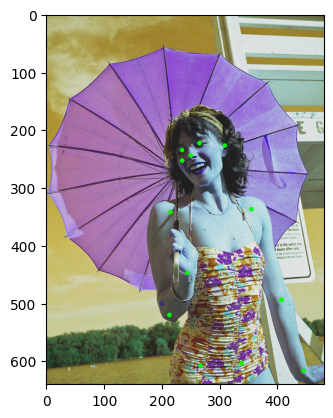

In [27]:
plt.imshow(new_img)

In [28]:
from data.display_utils import display_model
from models.smpl import get_smpl_model

In [29]:
model = get_smpl_model(use_hands=True,use_feet_keypoints=True,extra=True)

In [34]:
pose = torch.tensor(data[0]['parm_pose'])
betas = torch.tensor(data[0]['parm_shape'])

In [35]:
output = model(global_orient=pose.unsqueeze(0)[:,:1,:,:],body_pose=pose.unsqueeze(0)[:,1:,:,:],betas=betas.unsqueeze(0),pose2rot=False)

In [36]:
output.joints.shape

torch.Size([1, 49, 3])

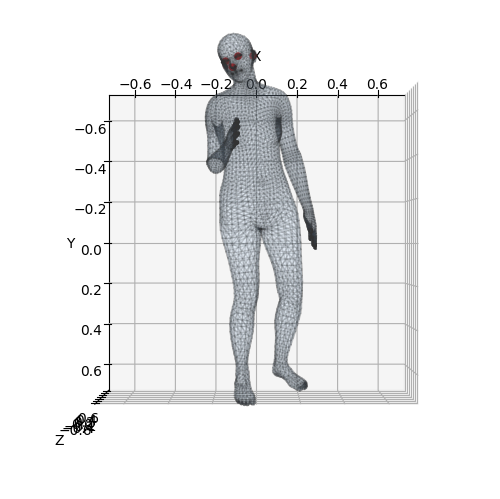

In [41]:
ax = display_model(
            {'verts': output.vertices.cpu().detach(),
             'joints': output.joints[0,:24,:].cpu().detach()},
            model_faces=model.faces.astype(int),
            with_joints=False,
            kintree_table=model.parents,
            savepath=None,
            show=False)
ax.view_init(elev=-90,azim=-90)
joints = output.joints.detach().cpu().numpy()
ax.scatter3D(joints[0,-5:,0],joints[0,-5:,1],joints[0,-5:,2],c='red')